/var/folders/wg/ksc5zbbx4kj8r8tc21_7fcwm0000gn/T/ipykernel_38783/2897722497.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chip_binned = chip.groupby("bin", dropna=True)["score"].max().reset_index()


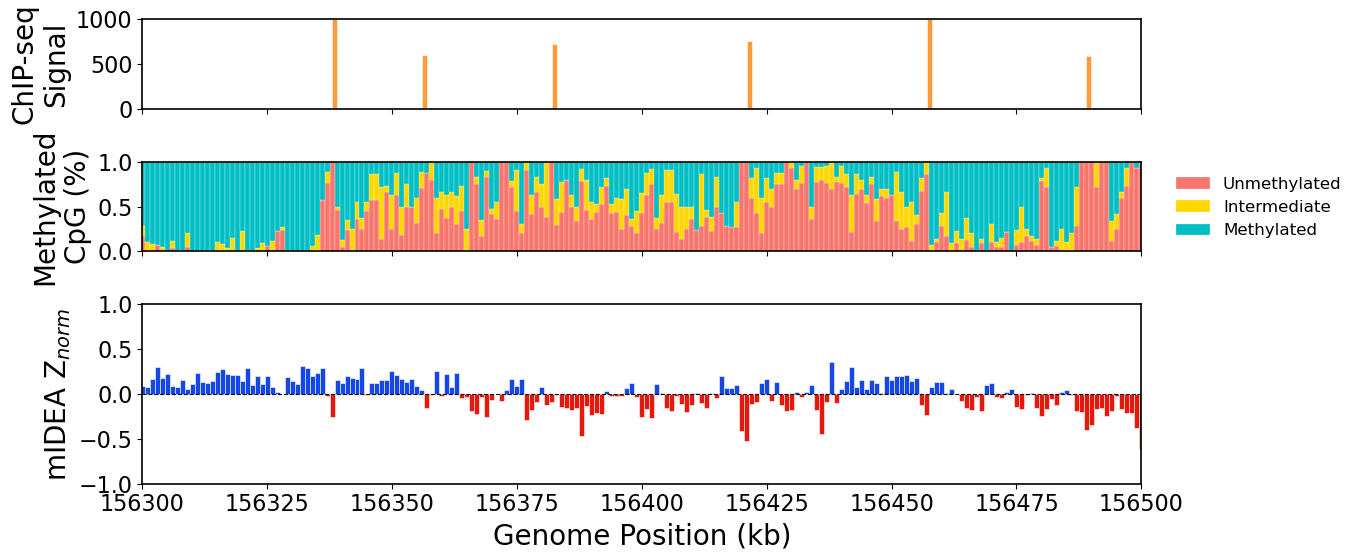

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import numpy as np

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 20

chip_path   = "MAX_chipseq_chr1_156000kb_157000kb.txt"
cpg_summary = "MAX_CpG_methylation_summary_3cat_per_kb.csv"   
midea_path  = "MAX_mIDEA_1mb_methyl_informed.txt"      

region_chr = "chr1"
xmin_kb, xmax_kb = 156300, 156500

colors = {
    'chip_seq': '#FE9A37',        
    'unmethylated': '#F8766D',    
    'intermediate': '#FFD700',    
    'methylated': '#00BFC4',      
    'positive_energy': '#1447E6', 
    'negative_energy': '#E7180B'  
}

chip_cols = ["chrom","start","end","name","score","strand","signalValue","pValue","qValue","peak"]
chip = pd.read_csv(chip_path, sep="\t", header=0, names=chip_cols)
chip = chip[chip["chrom"] == region_chr].copy()

bin_edges = np.arange(xmin_kb*1000, (xmax_kb+1)*1000, 1000)
chip["bin"] = pd.cut(chip["start"], bins=bin_edges, labels=bin_edges[:-1]//1000)
chip_binned = chip.groupby("bin", dropna=True)["score"].max().reset_index()
chip_binned["bin"] = chip_binned["bin"].astype(int)
chip_binned["score_norm"] = chip_binned["score"] / 1000 * 1000
chip_binned["width_kb"] = 1

df_cpg = pd.read_csv(cpg_summary)
df_cpg["bin"] = (df_cpg["start"] // 1000).astype(int)
df_cpg = df_cpg[(df_cpg["bin"] >= xmin_kb) & (df_cpg["bin"] <= xmax_kb)]

df_energy = pd.read_csv(midea_path, sep="\t")
df_energy["kb"] = df_energy["Index"] // 1000
df_energy = df_energy[(df_energy["kb"] >= xmin_kb) & (df_energy["kb"] <= xmax_kb)]
df_energy_grouped = (
    df_energy.groupby("kb", as_index=False)["Z_Energy_mg_methyl_informed"].mean()
)

fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(chip_binned["bin"], chip_binned["score_norm"],
        width=1, align="edge", color=colors['chip_seq'],
        edgecolor="white", linewidth=0.4)
ax1.set_ylabel("ChIP-seq\nSignal")
ax1.set_xlim(xmin_kb, xmax_kb)
ax1.set_ylim(0, 1000)
ax1.tick_params(labelbottom=False, labelsize=16)

ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2.bar(df_cpg["bin"], df_cpg["unmethylated_ratio"], width=1, 
        color=colors['unmethylated'], edgecolor="white", linewidth=0.2, label="Unmethylated")
ax2.bar(df_cpg["bin"], df_cpg["intermediate_ratio"], width=1, 
        bottom=df_cpg["unmethylated_ratio"],
        color=colors['intermediate'], edgecolor="white", linewidth=0.2, label="Intermediate")
ax2.bar(df_cpg["bin"], df_cpg["methylated_ratio"], width=1, 
        bottom=df_cpg["unmethylated_ratio"] + df_cpg["intermediate_ratio"],
        color=colors['methylated'], edgecolor="white", linewidth=0.2, label="Methylated")
ax2.set_ylabel("Methylated\nCpG (%)")
ax2.set_xlim(xmin_kb, xmax_kb)
ax2.set_ylim(0, 1)
ax2.tick_params(labelbottom=False, labelsize=16)
ax2.legend(fontsize=12, bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
pos = df_energy_grouped[df_energy_grouped["Z_Energy_mg_methyl_informed"] >= 0]
neg = df_energy_grouped[df_energy_grouped["Z_Energy_mg_methyl_informed"] < 0]
ax3.bar(pos["kb"], pos["Z_Energy_mg_methyl_informed"],
        width=1, color=colors['positive_energy'], edgecolor='white', linewidth=0.4)
ax3.bar(neg["kb"], neg["Z_Energy_mg_methyl_informed"],
        width=1, color=colors['negative_energy'], edgecolor='white', linewidth=0.4)
ax3.axhline(0, color="black", linestyle="--", linewidth=0.8)
ax3.set_ylabel("mIDEA Z$_{norm}$")
ax3.set_xlim(xmin_kb, xmax_kb)
ax3.set_ylim(-1, 1)
ax3.tick_params(labelsize=16)
ax3.set_xlabel("Genome Position (kb)")

fig.tight_layout()
# plt.savefig('MAX_mIDEA_genomic_optimized.pdf', format='pdf', bbox_inches='tight')
plt.show()

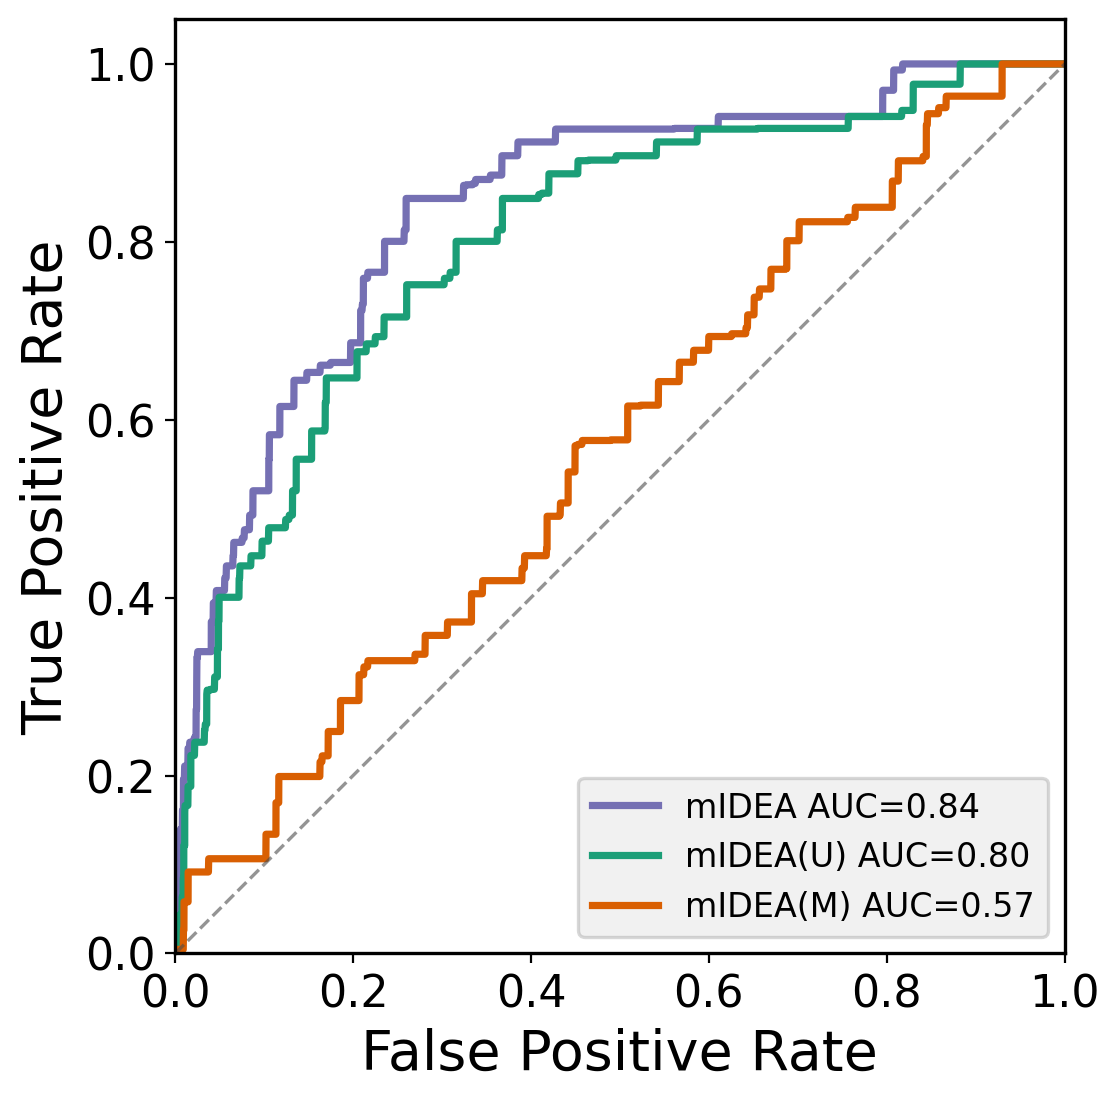

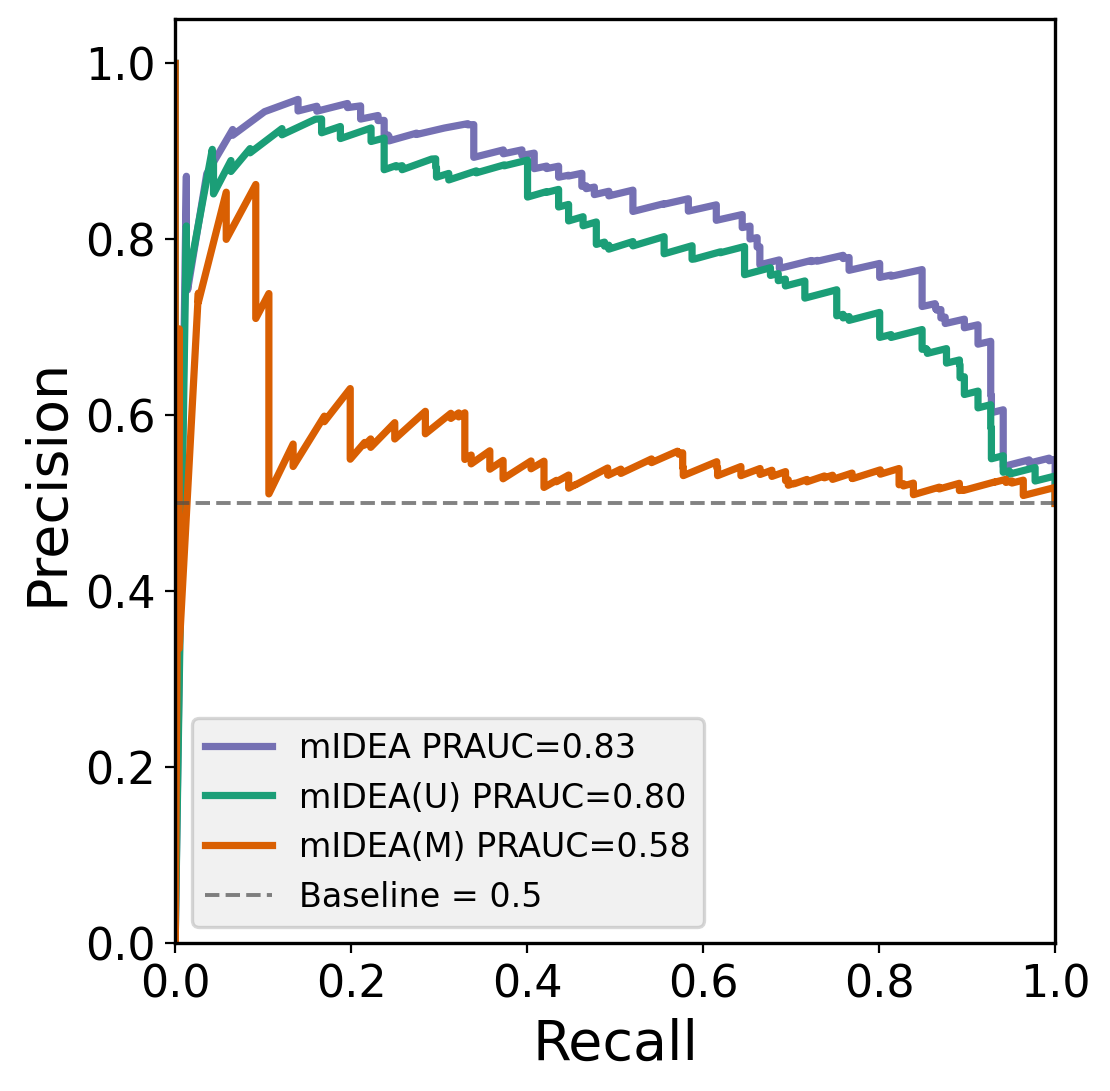

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
from matplotlib.ticker import MultipleLocator

midea_path  = "MAX_mIDEA_1mb_methyl_informed.txt"
chip_path   = "MAX_chipseq_chr1_156000kb_157000kb.txt"

chunk_size = 500  

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 20
plt.rcParams['lines.antialiased'] = True
plt.rcParams['axes.linewidth'] = 1.2

dfE = pd.read_csv(midea_path, sep="\t")
dfE['Index'] = dfE['Index'].astype(int)

def calculate_chunk_mean(df, column, chunk_size):
    values = []
    total_rows = len(df)
    for start in range(0, total_rows, chunk_size):
        end = min(start + chunk_size, total_rows)
        chunk_mean = df[column][start:end].mean()
        values.extend([chunk_mean] * (end - start))
    return values

dfE['unmethyl_mean']  = calculate_chunk_mean(dfE, 'Z_Energy_mg_unmethyl', chunk_size)
dfE['methyl_mean']    = calculate_chunk_mean(dfE, 'Z_Energy_mg_methyl', chunk_size)
dfE['informed_mean']  = calculate_chunk_mean(dfE, 'Z_Energy_mg_methyl_informed', chunk_size)

chip_cols = ["chrom","start","end","name","score","strand",
             "signalValue","pValue","qValue","peak"]
chip = pd.read_csv(chip_path, sep="\t", header=0, names=chip_cols)

dfE['group'] = 0
for _, row in chip.iterrows():
    s, e = row['start'], row['end']
    dfE.loc[(dfE['Index'] >= s) & (dfE['Index'] <= e), 'group'] = 1

def compute_roc_auc(y_true, scores):
    fpr, tpr, _ = roc_curve(y_true, -scores)
    return fpr, tpr, auc(fpr, tpr)

fpr_u, tpr_u, auc_u = compute_roc_auc(dfE['group'], dfE['unmethyl_mean'])
fpr_m, tpr_m, auc_m = compute_roc_auc(dfE['group'], dfE['methyl_mean'])
fpr_i, tpr_i, auc_i = compute_roc_auc(dfE['group'], dfE['informed_mean'])

fig_roc = plt.figure(figsize=(6, 6), dpi=200)
ax_roc = fig_roc.add_subplot(111)

colors = ['#1b9e77', '#d95f02', '#7570b3']

ax_roc.plot(fpr_i, tpr_i, lw=2.6, label=f'mIDEA AUC={auc_i:.2f}',   color=colors[2])
ax_roc.plot(fpr_u, tpr_u, lw=2.6, label=f'mIDEA(U) AUC={auc_u:.2f}', color=colors[0])
ax_roc.plot(fpr_m, tpr_m, lw=2.6, label=f'mIDEA(M) AUC={auc_m:.2f}', color=colors[1])

ax_roc.plot([0, 1], [0, 1], color='0.3', lw=1.2, linestyle='--', alpha=0.6)

ax_roc.set_xlim(0.0, 1.0)
ax_roc.set_ylim(0.0, 1.05)
ax_roc.tick_params(axis='x', labelsize=16)
ax_roc.tick_params(axis='y', labelsize=16)

ax_roc.set_xlabel('False Positive Rate', fontsize=20)
ax_roc.set_ylabel('True Positive Rate', fontsize=20)

ax_roc.xaxis.set_major_locator(MultipleLocator(0.2))
ax_roc.yaxis.set_major_locator(MultipleLocator(0.2))

legend_roc = ax_roc.legend(loc="lower right", fontsize=12)
legend_roc.get_frame().set_edgecolor('gray')
legend_roc.get_frame().set_linewidth(1.2)
legend_roc.get_frame().set_facecolor('lightgray')
legend_roc.get_frame().set_alpha(0.3)

fig_roc.tight_layout()
ax_roc.set_aspect('equal', adjustable='box')

fig_roc.savefig("ROC_mIDEA_3curves.pdf", format="pdf", bbox_inches="tight")

labels = dfE['group'].astype(int).values

classes = np.unique(labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
w_map = {c: w for c, w in zip(classes, class_weights)}
sample_weights = np.array([w_map[l] for l in labels])

def compute_pr_auc(y_true, scores, sample_weights):
    scores = -np.asarray(scores)  
    precision, recall, _ = precision_recall_curve(y_true, scores, sample_weight=sample_weights)
    ap = average_precision_score(y_true, scores, sample_weight=sample_weights)
    return precision, recall, ap

p_u, r_u, ap_u = compute_pr_auc(labels, dfE['unmethyl_mean'], sample_weights)
p_m, r_m, ap_m = compute_pr_auc(labels, dfE['methyl_mean'],   sample_weights)
p_i, r_i, ap_i = compute_pr_auc(labels, dfE['informed_mean'], sample_weights)

fig_pr = plt.figure(figsize=(6, 6), dpi=200)
ax_pr = fig_pr.add_subplot(111)

ax_pr.plot(r_i, p_i, lw=2.6, label=f'mIDEA PRAUC={ap_i:.2f}',   color=colors[2])
ax_pr.plot(r_u, p_u, lw=2.6, label=f'mIDEA(U) PRAUC={ap_u:.2f}', color=colors[0])
ax_pr.plot(r_m, p_m, lw=2.6, label=f'mIDEA(M) PRAUC={ap_m:.2f}', color=colors[1])

ax_pr.axhline(0.5, linestyle='--', lw=1.4, alpha=0.7, color='0.3',
              label='Baseline = 0.5')

ax_pr.set_xlim(0.0, 1.0)
ax_pr.set_ylim(0.0, 1.05)
ax_pr.tick_params(axis='x', labelsize=16)
ax_pr.tick_params(axis='y', labelsize=16)

ax_pr.set_xlabel('Recall', fontsize=20)
ax_pr.set_ylabel('Precision', fontsize=20)

ax_pr.xaxis.set_major_locator(MultipleLocator(0.2))
ax_pr.yaxis.set_major_locator(MultipleLocator(0.2))

legend_pr = ax_pr.legend(loc="lower left", fontsize=12)
legend_pr.get_frame().set_edgecolor('gray')
legend_pr.get_frame().set_linewidth(1.2)
legend_pr.get_frame().set_facecolor('lightgray')
legend_pr.get_frame().set_alpha(0.3)

ax_pr.set_aspect('equal', adjustable='box')

# fig_pr.savefig("PR_mIDEA_3curves.pdf", bbox_inches="tight")

plt.show()
